In [3]:
import numpy as np 
import pandas as pd  
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [39]:
train_df = pd.read_csv('./data/emnist-balanced-train.csv', header=None)
test_df = pd.read_csv('./data/emnist-balanced-test.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Data analysis

In [40]:
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]
X_test = test_df.loc[:, 1:]
y_test = test_df.loc[:, 0]

X_train.shape, y_train.shape

((112800, 784), (112800,))

In [41]:
label_map = pd.read_csv("./data/emnist-balanced-mapping.txt", 
                        delimiter = ' ', 
                        index_col=0, 
                        header=None).squeeze()
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

Data visualisation and reshaping

In [42]:
sample_image = X_train.iloc[42]
sample_label = y_train.iloc[42]
sample_image.shape, sample_label

((784,), 23)

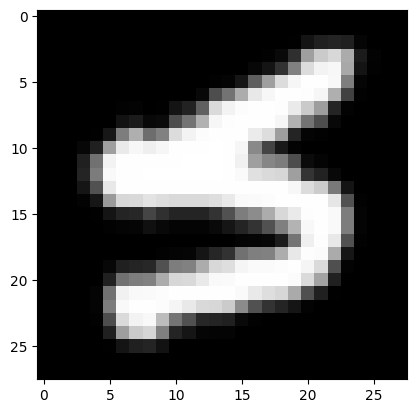

N


In [43]:
plt.imshow(sample_image.values.reshape(28,28), cmap=plt.cm.gray)
plt.show()
print(label_dictionary[sample_label])

In [44]:
def reshape_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image
X_train = np.apply_along_axis(reshape_and_rotate, 1, X_train.values)
X_test = np.apply_along_axis(reshape_and_rotate, 1, X_test.values)
X_train.shape

(112800, 28, 28)

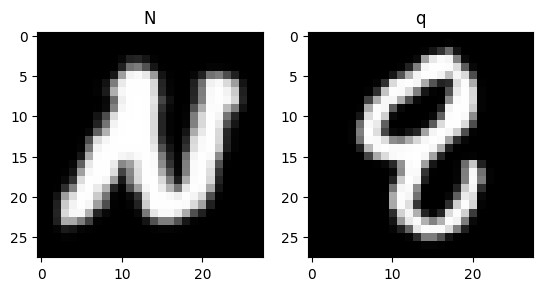

In [46]:
plt.subplot(1, 2, 1)
sample_image = X_train[42]
sample_label = y_train.iloc[42]
plt.imshow(sample_image,cmap=plt.cm.gray)
plt.title(label_dictionary[sample_label])

plt.subplot(1, 2, 2)
sample_image = X_test[42]
sample_label = y_test.iloc[42]
plt.imshow(sample_image,cmap=plt.cm.gray)
plt.title(label_dictionary[sample_label])
plt.show()

Data normalization and encoding

In [47]:
X_train = X_train.astype('float32') / 255
X_train = X_train.reshape(-1,1,28,28)

X_test = X_test.astype('float32') / 255
X_test = X_test.reshape(-1,1,28,28)

X_train.shape,y_train.shape
X_test.shape,y_test.shape

((18800, 1, 28, 28), (18800,))

In [49]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
 
train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=32)
test_dataloader = DataLoader(list(zip(X_test,y_test)), batch_size=32)

In [50]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(test_features_batch.shape, test_labels_batch.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])
torch.Size([32, 1, 28, 28]) torch.Size([32])
